# Cohort 7.3 MS vs ELISA

### Imports and environment setup

- Date of run: 2025-06-06
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import cohort_analysis_utils as utils
import ms_utils as ms_utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

## Load MS data

In [4]:
df_116 = ms_utils.load_7_3_pg_matrix(
    pg_matrix_path='../data/ms/cohort_7_3_MS_pg.csv',
    metadata_path='../data/cohort_7.3_metadata.csv',
    nan_thresh=None,
    log2_transform=True,
    median_normalize=False
)
df_105 = df_116.dropna(thresh=5000)


In [5]:
df_116_norm = ms_utils.load_7_3_pg_matrix(
    pg_matrix_path='../data/ms/cohort_7_3_MS_pg.csv',
    metadata_path='../data/cohort_7.3_metadata.csv',
    nan_thresh=None,
    log2_transform=True,
    median_normalize=True
)
df_105_norm = df_116_norm.dropna(thresh=5000)

In [6]:
MMK_BIOMARKERS = ["AGRIN_HUMAN", "MMP9_HUMAN", "TIMP2_HUMAN", 
                    "KPYM_HUMAN", "PERM_HUMAN", "MVP_HUMAN", "NGAL_HUMAN", "CLIC1_HUMAN", 
                    "PIGR_HUMAN"]


In [7]:
RATIOS_MS = []
for bmk in MMK_BIOMARKERS:
    for bmk2 in MMK_BIOMARKERS:
        if bmk != bmk2:
            ratio_name = f"{bmk.replace("_HUMAN","")}_{bmk2.replace("_HUMAN","")}"
            # Substracting because the biomarkers are already log2 transformed
            df_116[ratio_name] = df_116[bmk] - df_116[bmk2]
            df_105[ratio_name] = df_105[bmk] - df_105[bmk2]
            df_116_norm[ratio_name] = df_116_norm[bmk] - df_116_norm[bmk2]
            df_105_norm[ratio_name] = df_105_norm[bmk] - df_105_norm[bmk2]
            # Append the ratio name to the list
            RATIOS_MS.append(ratio_name)

## Load ELISA data

In [8]:
df_elisa = pd.read_csv('../data/cohort_7.3_20250527.csv', sep='\t', index_col=0, header=0)

df_elisa = utils.cols_as_category(df_elisa, {'Pathology':{'Benigna': 0, 'EC': 1}})

df_elisa.index.name = None


BIOMARKERS = ["MMP9", "KPYM", "AGRIN", "TIMP2", "MVP", "PERM", "CLIC1"]

for biomarker in BIOMARKERS:
    df_elisa[biomarker] =  pd.to_numeric(df_elisa[biomarker], errors='coerce')

# Create new columns with the ratios between the biomarkers
RATIOS_ELISA = []
for biomarker1 in BIOMARKERS:
    for biomarker2 in BIOMARKERS:
        if biomarker1 != biomarker2:
            df_elisa[f'{biomarker1}_{biomarker2}'] = df_elisa[f'{biomarker1}'] / df_elisa[f'{biomarker2}']
            # Make infinite values NaN
            df_elisa[f'{biomarker1}_{biomarker2}'] = df_elisa[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
            # Apply log2 transformation to the ratios
            df_elisa[f'{biomarker1}_{biomarker2}'] = np.log2(df_elisa[f'{biomarker1}_{biomarker2}'])

            RATIOS_ELISA.append(f'{biomarker1}_{biomarker2}')

In [9]:
df_elisa[RATIOS_ELISA].head()

,MMP9_KPYM,MMP9_AGRIN,MMP9_TIMP2,MMP9_MVP,MMP9_PERM,MMP9_CLIC1,KPYM_MMP9,KPYM_AGRIN,KPYM_TIMP2,KPYM_MVP,...,PERM_AGRIN,PERM_TIMP2,PERM_MVP,PERM_CLIC1,CLIC1_MMP9,CLIC1_KPYM,CLIC1_AGRIN,CLIC1_TIMP2,CLIC1_MVP,CLIC1_PERM
020-0174,-4.649521,-2.142730,-0.312751,-3.627304,-2.100082,-5.673039,4.649521,2.506791,4.336770,1.022217,...,-0.042647,1.787331,-1.527222,-3.572957,5.673039,1.023518,3.530309,5.360288,2.045735,3.572957
001-0195,-4.837588,-2.994366,-2.430638,-2.972023,-4.505357,-4.909433,4.837588,1.843222,2.406950,1.865565,...,1.510991,2.074719,1.533334,-0.404076,4.909433,0.071845,1.915067,2.478795,1.937410,0.404076
020-0057,-3.854628,-1.112848,0.602804,-2.755170,-2.976649,-4.437043,3.854628,2.741781,4.457433,1.099459,...,1.863801,3.579453,0.221479,-1.460394,4.437043,0.582415,3.324196,5.039848,1.681873,1.460394
001-0025,NaN,-0.402859,1.383614,-1.170682,-3.701102,-3.145353,NaN,NaN,NaN,NaN,...,3.298242,5.084716,2.530419,0.555749,3.145353,NaN,2.742494,4.528967,1.974671,-0.555749
032-0016,-3.092851,-1.994024,0.280591,-1.137596,-3.382830,-4.415212,3.092851,1.098828,3.373442,1.955256,...,1.388806,3.663421,2.245234,-1.032382,4.415212,1.322361,2.421188,4.695803,3.277616,1.032382


In [10]:
# Compare RATIOS_MS and RATIOS_ELISA size and intersection
print(f"Number of MS ratios: {len(RATIOS_MS)}")
print(f"Number of ELISA ratios: {len(RATIOS_ELISA)}")
print(f"Intersection size: {len(set(RATIOS_MS).intersection(set(RATIOS_ELISA)))}")

Number of MS ratios: 72
Number of ELISA ratios: 42
Intersection size: 42


In [11]:
bloody_samples = list(set(df_116.index) - set(df_105.index))


## Compute correlations

In [12]:
# Remove _HUMAN suffix from the biomarkers in ms if the substsring is present
df_116.columns = [col.replace('_HUMAN', '') if '_HUMAN' in col else col for col in df_116.columns]
df_105.columns = [col.replace('_HUMAN', '') if '_HUMAN' in col else col for col in df_105.columns]
df_116_norm.columns = [col.replace('_HUMAN', '') if '_HUMAN' in col else col for col in df_116_norm.columns]
df_105_norm.columns = [col.replace('_HUMAN', '') if '_HUMAN' in col else col for col in df_105_norm.columns]

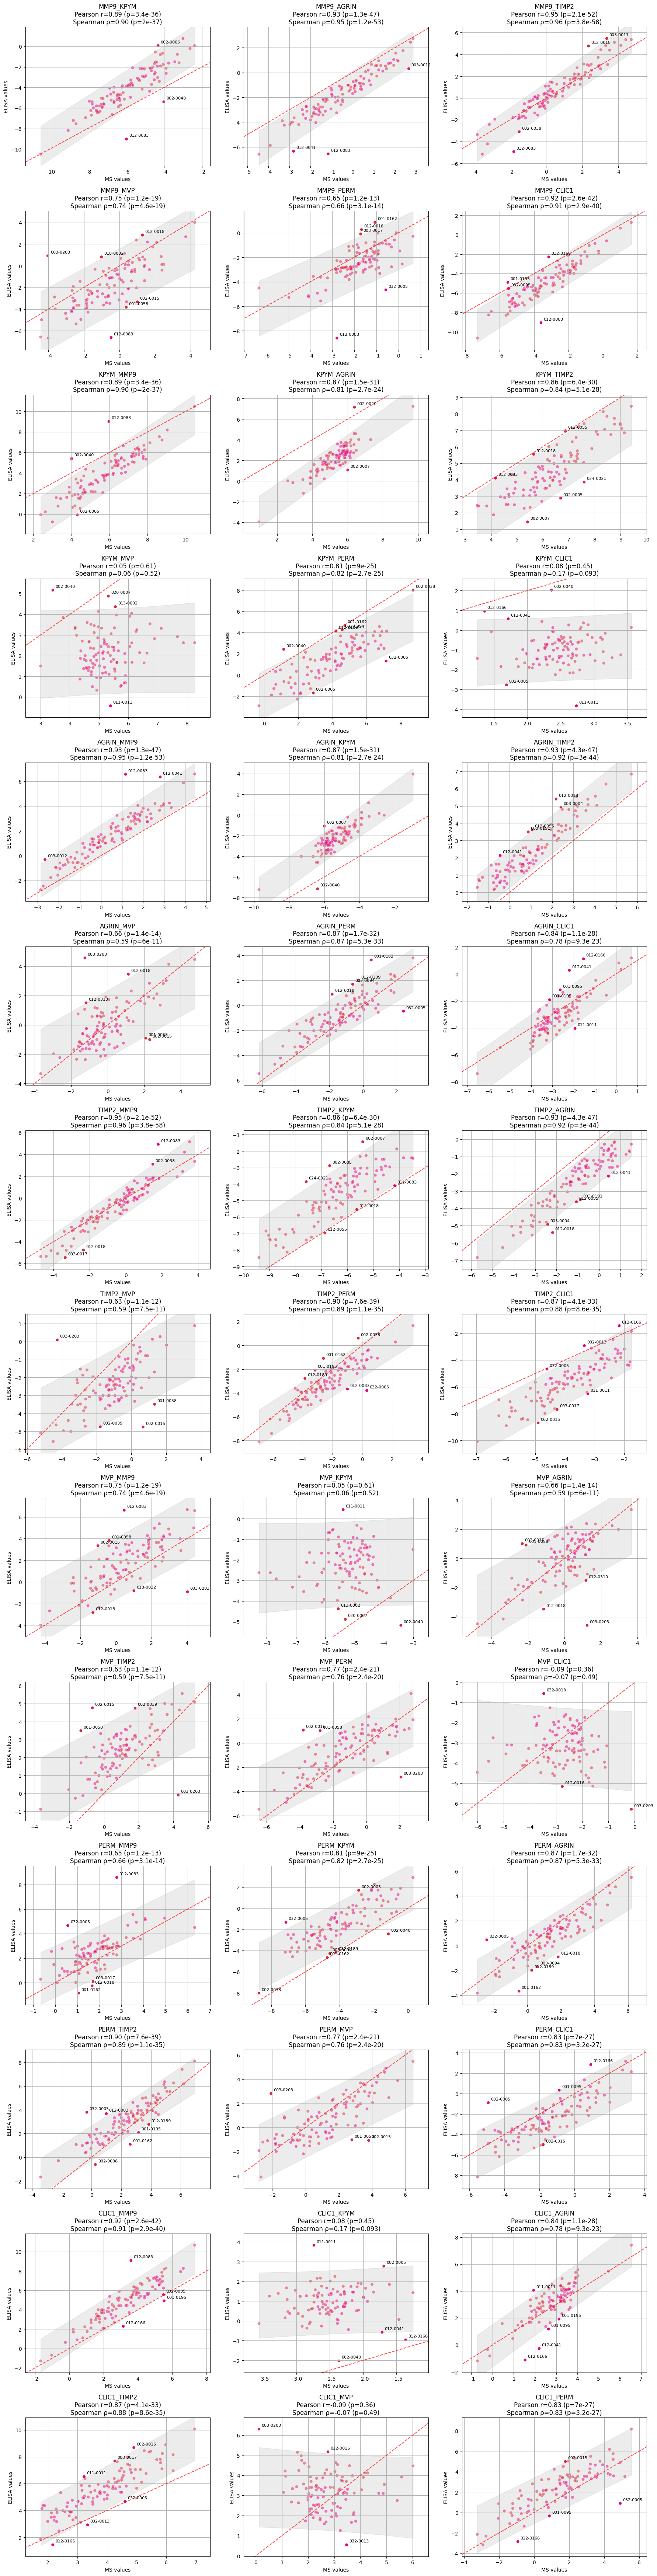

In [13]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt
import seaborn as sns

# Define Mimark's pink and red (replace with your actual hex codes if needed)
mimark_palette = {
    0: '#E6007A',  # Mimark pink
    1: '#D7263D',  # Mimark red
}

df_ms = df_105.copy()

ratios_to_plot = [ratio for ratio in RATIOS_ELISA if ratio in df_ms.columns and ratio in df_elisa.columns]
n = len(ratios_to_plot)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

# Dictionary to track outliers
outlier_summary = {}

for idx, ratio in enumerate(ratios_to_plot):
    s_ms = df_ms[ratio].copy()
    s_elisa = df_elisa[ratio].copy()

    # Remove rows with NaN as index or duplicate indices
    s_ms = s_ms[~s_ms.index.isna()]
    s_elisa = s_elisa[~s_elisa.index.isna()]
    s_ms = s_ms[~s_ms.index.duplicated(keep='first')]
    s_elisa = s_elisa[~s_elisa.index.duplicated(keep='first')]

    # Combine into a single DataFrame, aligning on index
    df_plot = pd.DataFrame({'MS': s_ms, 'ELISA': s_elisa}).dropna()

    # Add Pathology and Bloody columns
    df_plot['Pathology'] = df_ms.loc[df_plot.index, 'Pathology']
    df_plot['Bloody'] = df_plot.index.isin(bloody_samples)

    # Linear regression for confidence interval
    slope, intercept, r_value, p_value, std_err = linregress(df_plot['MS'], df_plot['ELISA'])
    y_pred = intercept + slope * df_plot['MS']
    residuals = df_plot['ELISA'] - y_pred
    dof = len(df_plot) - 2
    t_val = 1.96  # Approximate for 95% CI

    # Standard error of prediction
    s_err = np.sqrt(np.sum(residuals**2) / dof)
    x = df_plot['MS']
    mean_x = np.mean(x)
    n_points = len(x)
    pred_interval = t_val * s_err * np.sqrt(1 + 1/n_points + (x - mean_x)**2 / np.sum((x - mean_x)**2))

    # Find outliers: outside the prediction interval
    outliers = (df_plot['ELISA'] > y_pred + pred_interval) | (df_plot['ELISA'] < y_pred - pred_interval)
    df_plot['Outlier'] = outliers

    # Track outliers for summary
    for sample_id in df_plot.index[outliers]:
        if sample_id not in outlier_summary:
            outlier_summary[sample_id] = []
        outlier_summary[sample_id].append(ratio)

    ax = axes[idx]
    unique_pathologies = df_plot['Pathology'].unique()
    palette = {p: mimark_palette.get(p, '#333333') for p in unique_pathologies}

    # Plot non-outliers with alpha=0.05
    sns.scatterplot(
        x='MS', y='ELISA', data=df_plot[~df_plot['Outlier']], ax=ax,
        hue='Pathology',
        style='Bloody',
        markers={False: 'o', True: 'X'},
        palette=palette,
        legend=False,
        alpha=0.5
    )
    # Plot outliers with alpha=1
    sns.scatterplot(
        x='MS', y='ELISA', data=df_plot[df_plot['Outlier']], ax=ax,
        hue='Pathology',
        style='Bloody',
        markers={False: 'o', True: 'X'},
        palette=palette,
        legend=False,
        alpha=1
    )

    # Annotate only outliers
    for sample_id in df_plot.index[outliers]:
        ax.annotate(str(sample_id),
                    (df_plot.loc[sample_id, 'MS'], df_plot.loc[sample_id, 'ELISA']),
                    textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, color='black')

    # Plot prediction interval area (almost transparent)
    x_sorted = np.sort(df_plot['MS'].values)
    y_pred_sorted = intercept + slope * x_sorted
    pred_interval_sorted = t_val * s_err * np.sqrt(1 + 1/n_points + (x_sorted - mean_x)**2 / np.sum((x - mean_x)**2))
    lower = y_pred_sorted - pred_interval_sorted
    upper = y_pred_sorted + pred_interval_sorted
    ax.fill_between(x_sorted, lower, upper, color='grey', alpha=0.15, zorder=0)

    # Dynamic axis limits with margin
    x_min, x_max = df_plot['MS'].min(), df_plot['MS'].max()
    y_min, y_max = df_plot['ELISA'].min(), df_plot['ELISA'].max()
    x_margin = (x_max - x_min) * 0.1 if x_max > x_min else 1
    y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 1
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    # Add y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.7)

    # Correlations
    pearson_corr, pearson_p = pearsonr(df_plot['MS'], df_plot['ELISA'])
    spearman_corr, spearman_p = spearmanr(df_plot['MS'], df_plot['ELISA'])
    ax.set_title(f'{ratio}\n'
                 f'Pearson r={pearson_corr:.2f} (p={pearson_p:.2g})\n'
                 f'Spearman ρ={spearman_corr:.2f} (p={spearman_p:.2g})')
    ax.set_xlabel('MS values')
    ax.set_ylabel('ELISA values')
    ax.grid()

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [14]:
# Collect all unique biomarkers from the ratios
biomarkers = set()
for ratios in outlier_summary.values():
    for ratio in ratios:
        biomarkers.update(ratio.split('_'))
biomarkers = sorted(biomarkers)

# Build the summary table
rows = []
for sample_id, ratios in outlier_summary.items():
    marker = 'X' if sample_id in bloody_samples else 'O'
    biomarker_counts = {bm: 0 for bm in biomarkers}
    for ratio in ratios:
        for bm in ratio.split('_'):
            biomarker_counts[bm] += 0.5
    row = {'Sample': sample_id, 'Marker': marker, 'Total': len(ratios)/2}
    row.update(biomarker_counts)
    rows.append(row)

df_outlier_table = pd.DataFrame(rows)
df_outlier_table = df_outlier_table[['Marker', 'Sample', 'Total'] + biomarkers]
df_outlier_table = df_outlier_table.sort_values(by='Total', ascending=False)

print("\nOutlier summary table:")
print(df_outlier_table.to_string(index=False))


Outlier summary table:
Marker   Sample  Total  AGRIN  CLIC1  KPYM  MMP9  MVP  PERM  TIMP2
     O 012-0083    8.0    1.0    1.0   2.0   6.0  1.0   2.0    3.0
     O 032-0005    7.0    1.0    3.0   1.0   2.0  0.0   5.0    2.0
     O 012-0018    7.0    3.0    0.0   1.0   3.0  2.0   2.0    3.0
     O 002-0015    6.0    1.0    2.0   0.0   1.0  4.0   2.0    2.0
     O 003-0203    5.0    1.0    1.0   0.0   1.0  5.0   1.0    1.0
     O 002-0040    5.0    1.0    1.0   5.0   1.0  1.0   1.0    0.0
     O 012-0166    5.0    1.0    5.0   1.0   1.0  0.0   1.0    1.0
     O 001-0058    4.0    1.0    0.0   0.0   1.0  4.0   1.0    1.0
     O 001-0162    4.0    1.0    0.0   1.0   1.0  0.0   4.0    1.0
     O 012-0041    4.0    3.0    2.0   1.0   1.0  0.0   0.0    1.0
     O 002-0005    4.0    0.0    1.0   4.0   1.0  0.0   1.0    1.0
     O 011-0011    4.0    1.0    3.0   2.0   0.0  1.0   0.0    1.0
     O 003-0017    3.0    0.0    1.0   0.0   2.0  0.0   1.0    2.0
     O 001-0195    3.0    1.0    2.0  

In [15]:
df_outlier_table

,Marker,Sample,Total,AGRIN,CLIC1,KPYM,MMP9,MVP,PERM,TIMP2
2,O,012-0083,8.0,1.0,1.0,2.0,6.0,1.0,2.0,3.0
13,O,032-0005,7.0,1.0,3.0,1.0,2.0,0.0,5.0,2.0
7,O,012-0018,7.0,3.0,0.0,1.0,3.0,2.0,2.0,3.0
9,O,002-0015,6.0,1.0,2.0,0.0,1.0,4.0,2.0,2.0
10,O,003-0203,5.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0
1,O,002-0040,5.0,1.0,1.0,5.0,1.0,1.0,1.0,0.0
15,O,012-0166,5.0,1.0,5.0,1.0,1.0,0.0,1.0,1.0
8,O,001-0058,4.0,1.0,0.0,0.0,1.0,4.0,1.0,1.0
12,O,001-0162,4.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0
4,O,012-0041,4.0,3.0,2.0,1.0,1.0,0.0,0.0,1.0


## Single biomarker correlations

In [16]:
# Create a df_elisa_norm taking 'AGRIN', 'KPYM', 'MMP9', 'TIMP2', 'MVP', 'PERM', 'CLIC1' and 
# normalizing it with the column Total_protein
df_elisa_norm = df_elisa.copy()
df_elisa_norm['AGRIN'] = df_elisa_norm['AGRIN'] / df_elisa_norm['Total_protein']
df_elisa_norm['KPYM'] = df_elisa_norm['KPYM'] / df_elisa_norm['Total_protein']
df_elisa_norm['MMP9'] = df_elisa_norm['MMP9'] / df_elisa_norm['Total_protein']
df_elisa_norm['TIMP2'] = df_elisa_norm['TIMP2'] / df_elisa_norm['Total_protein']
df_elisa_norm['MVP'] = df_elisa_norm['MVP'] / df_elisa_norm['Total_protein']
df_elisa_norm['PERM'] = df_elisa_norm['PERM'] / df_elisa_norm['Total_protein']
df_elisa_norm['CLIC1'] = df_elisa_norm['CLIC1'] / df_elisa_norm['Total_protein'] 

In [17]:
def plot_ms_vs_elisa_correlation(
    df_ms,
    df_elisa,
    biomarkers_to_plot,
    pathology_col='Pathology',
    bloody_samples=None,
    palette=None,
    log2_elisa=True,
    ncols=4,
    highlight_outliers=False,
    figsize=(12, 3),
    save_fig=False,
    save_path=None
):
    """
    Plot correlation between MS and ELISA for given biomarkers.

    Args:
        df_ms (pd.DataFrame): MS dataframe (index: sample, columns: biomarkers).
        df_elisa (pd.DataFrame): ELISA dataframe (index: sample, columns: biomarkers).
        biomarkers_to_plot (list): List of biomarker names to plot.
        pathology_col (str): Name of the pathology column in df_ms.
        bloody_samples (list or set): List of sample IDs considered 'bloody'.
        palette (dict): Dict mapping pathology values to colors.
        log2_elisa (bool): Whether to log2-transform ELISA values.
        ncols (int): Number of columns in subplot grid.
        figsize (tuple): Figure size.
        save_fig (bool): Whether to save the figure.
        save_path (str): Path to save the figure if save_fig is True.
    """
    n = len(biomarkers_to_plot)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    outlier_summary = {}

    for idx, biomarker in enumerate(biomarkers_to_plot):
        s_ms = df_ms[biomarker].copy()
        s_elisa = df_elisa[biomarker].copy()

        # Remove rows with NaN as index or duplicate indices
        s_ms = s_ms[~s_ms.index.isna()]
        s_elisa = s_elisa[~s_elisa.index.isna()]
        s_ms = s_ms[~s_ms.index.duplicated(keep='first')]
        s_elisa = s_elisa[~s_elisa.index.duplicated(keep='first')]

        # Combine into a single DataFrame, aligning on index
        df_plot = pd.DataFrame({'MS': s_ms, 'ELISA': s_elisa}).dropna()

        # Optionally log2-transform ELISA values
        if log2_elisa:
            df_plot['ELISA'] = np.log2(df_plot['ELISA'])

        # Add Pathology and Bloody columns
        df_plot['Pathology'] = df_ms.loc[df_plot.index, pathology_col]
        if bloody_samples is not None:
            df_plot['Bloody'] = df_plot.index.isin(bloody_samples)
        else:
            df_plot['Bloody'] = False

        # Ensure numeric dtype
        df_plot['MS'] = pd.to_numeric(df_plot['MS'], errors='coerce')
        df_plot['ELISA'] = pd.to_numeric(df_plot['ELISA'], errors='coerce')
        df_plot = df_plot.dropna(subset=['MS', 'ELISA'])

        # Skip if not enough data
        if len(df_plot) < 3:
            continue

        # Linear regression for confidence interval
        slope, intercept, r_value, p_value, std_err = linregress(df_plot['MS'], df_plot['ELISA'])
        y_pred = intercept + slope * df_plot['MS']
        residuals = df_plot['ELISA'] - y_pred
        dof = len(df_plot) - 2
        t_val = 1.96  # Approximate for 95% CI

        s_err = np.sqrt(np.sum(residuals**2) / dof)
        x = df_plot['MS']
        mean_x = np.mean(x)
        n_points = len(x)
        pred_interval = t_val * s_err * np.sqrt(1 + 1/n_points + (x - mean_x)**2 / np.sum((x - mean_x)**2))

        outliers = (df_plot['ELISA'] > y_pred + pred_interval) | (df_plot['ELISA'] < y_pred - pred_interval)
        df_plot['Outlier'] = outliers

        for sample_id in df_plot.index[outliers]:
            if sample_id not in outlier_summary:
                outlier_summary[sample_id] = []
            outlier_summary[sample_id].append(biomarker)

        ax = axes[idx]
        unique_pathologies = df_plot['Pathology'].unique()

        # Default palette if not provided
        if palette is None:
            palette = {0: 'black', 1: 'red'}

        # Plot non-outliers
        sns.scatterplot(
            x='MS', y='ELISA', data=df_plot[~df_plot['Outlier']], ax=ax,
            hue='Pathology',
            style='Bloody',
            markers={False: 'o', True: 'X'},
            palette=palette,
            legend=False,
            alpha=0.5
        )
        # Plot outliers
        sns.scatterplot(
            x='MS', y='ELISA', data=df_plot[df_plot['Outlier']], ax=ax,
            hue='Pathology',
            style='Bloody',
            markers={False: 'o', True: 'X'},
            palette=palette,
            legend=False,
            alpha=1
        )

        if highlight_outliers:
            for sample_id in df_plot.index[outliers]:
                ax.annotate(str(sample_id),
                            (df_plot.loc[sample_id, 'MS'], df_plot.loc[sample_id, 'ELISA']),
                            textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, color='black')

        x_sorted = np.sort(df_plot['MS'].values)
        y_pred_sorted = intercept + slope * x_sorted
        pred_interval_sorted = t_val * s_err * np.sqrt(1 + 1/n_points + (x_sorted - mean_x)**2 / np.sum((x_sorted - mean_x)**2))
        lower = y_pred_sorted - pred_interval_sorted
        upper = y_pred_sorted + pred_interval_sorted
        ax.fill_between(x_sorted, lower, upper, color='grey', alpha=0.15, zorder=0)

        x_min, x_max = df_plot['MS'].min(), df_plot['MS'].max()
        y_min, y_max = df_plot['ELISA'].min(), df_plot['ELISA'].max()
        x_margin = (x_max - x_min) * 0.1 if x_max > x_min else 1
        y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 1
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'r--', alpha=0.7)

        pearson_corr, pearson_p = pearsonr(df_plot['MS'], df_plot['ELISA'])
        spearman_corr, spearman_p = spearmanr(df_plot['MS'], df_plot['ELISA'])
        ax.set_title(f'{biomarker}\n'
                     f'Pearson r={pearson_corr:.2f} (p={pearson_p:.2g})\n'
                     f'Spearman ρ={spearman_corr:.2f} (p={spearman_p:.2g})')
        ax.set_xlabel('MS values')
        ax.set_ylabel('ELISA values')
        ax.grid()

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    if save_fig:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, format='svg')
        print(f"Figure saved to {save_path}")

    plt.tight_layout()
    plt.show()

    return outlier_summary

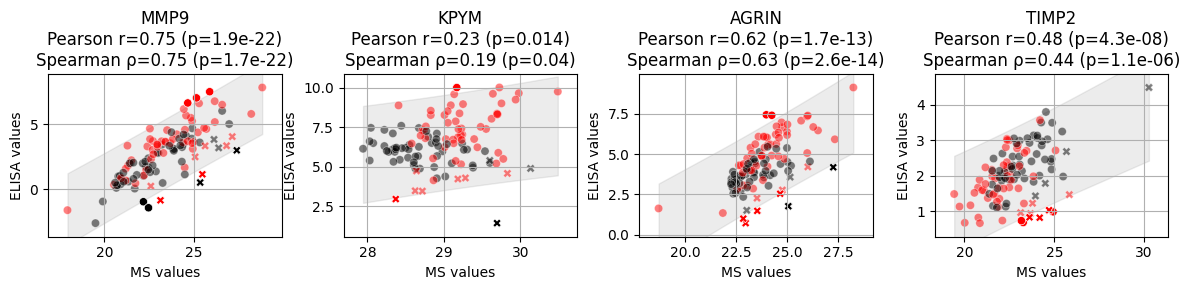

In [18]:
outlier_summary = plot_ms_vs_elisa_correlation(
    df_116,
    df_elisa_norm,
    biomarkers_to_plot=["MMP9", "KPYM", "AGRIN", "TIMP2"],
    pathology_col='Pathology',
    bloody_samples=bloody_samples,
    palette={0: 'black', 1: 'red'},
    log2_elisa=True,
    ncols=4,
    figsize=(12, 3)
)

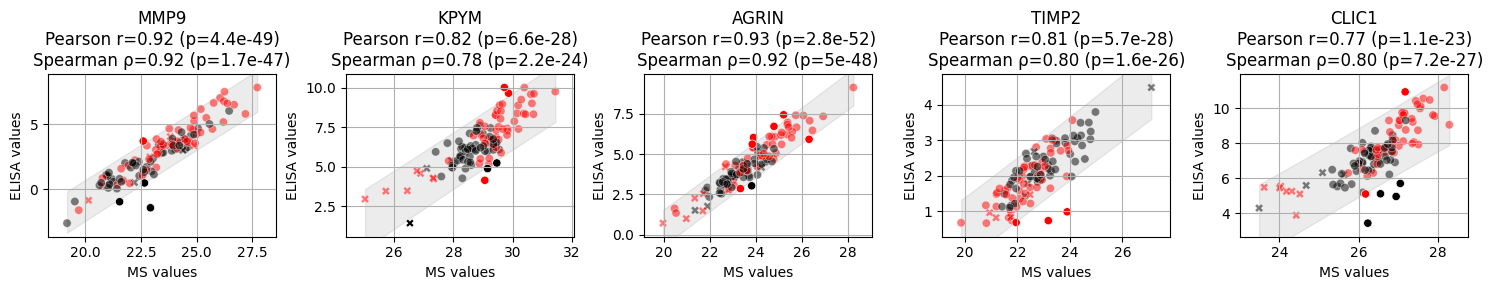

In [63]:
outlier_summary = plot_ms_vs_elisa_correlation(
    df_116_norm,
    df_elisa_norm,
    biomarkers_to_plot=["MMP9", "KPYM", "AGRIN", "TIMP2", "CLIC1"],
    pathology_col='Pathology',
    bloody_samples=bloody_samples,
    palette={0: 'black', 1: 'red'},
    log2_elisa=True,
    ncols=5,
    figsize=(15, 3),
    save_fig=False,
    save_path='/home/leandro/Desktop/Fig1.svg'  
)

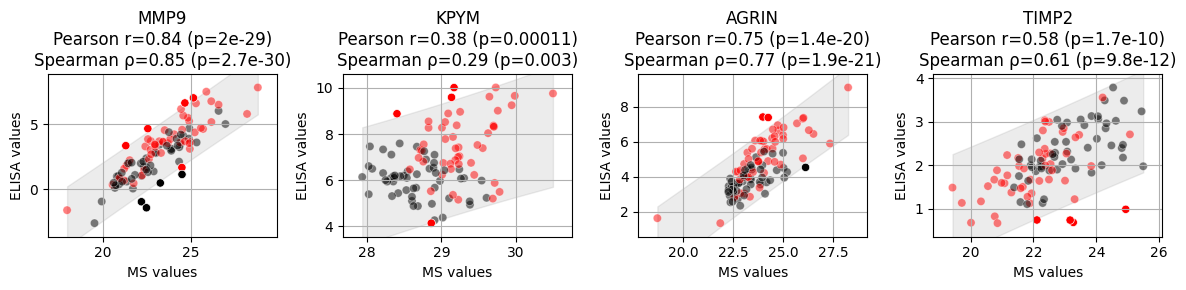

In [20]:
outlier_summary = plot_ms_vs_elisa_correlation(
    df_105,
    df_elisa_norm,
    biomarkers_to_plot=["MMP9", "KPYM", "AGRIN", "TIMP2"],
    pathology_col='Pathology',
    bloody_samples=bloody_samples,
    palette={0: 'black', 1: 'red'},
    log2_elisa=True,
    ncols=4,
    figsize=(12, 3)
)

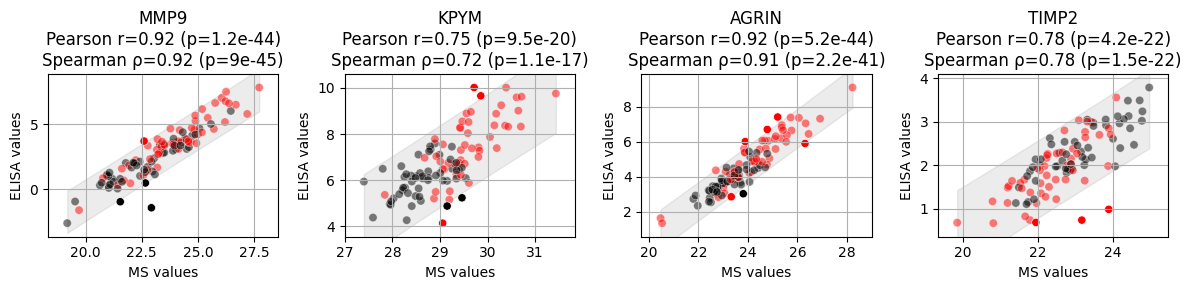

In [21]:
outlier_summary = plot_ms_vs_elisa_correlation(
    df_105_norm,
    df_elisa_norm,
    biomarkers_to_plot=["MMP9", "KPYM", "AGRIN", "TIMP2"],
    pathology_col='Pathology',
    bloody_samples=bloody_samples,
    palette={0: 'black', 1: 'red'},
    log2_elisa=True,
    ncols=4,
    figsize=(12, 3)
)

## AUCS in MS an ELISA for single BMKs


In [22]:
MMK_BIOMARKERS = ["AGRIN", "MMP9", "TIMP2", "KPYM", "PERM", "MVP", "CLIC1"]

In [23]:
df_105_norm_res = ms_utils.compute_ms_biomarker_metrics(df_105_norm)

In [24]:
df_105_norm_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.797,0.615,0.887,0.962,0.226,1.158,52,53,1.611e-07,2.289e-06
MMP9,0.727,0.750,0.642,0.962,0.264,1.376,52,53,6.268e-05,3.732e-04
TIMP2,0.679,0.635,0.642,0.981,0.264,-0.681,52,53,1.597e-03,6.035e-03
KPYM,0.876,0.923,0.679,0.962,0.415,0.963,52,53,3.073e-11,1.860e-09
PERM,0.698,0.731,0.679,0.981,0.170,1.377,52,53,4.834e-04,2.145e-03
MVP,0.667,0.615,0.717,0.962,0.038,0.744,52,53,3.230e-03,1.113e-02
CLIC1,0.810,0.615,0.887,0.962,0.208,0.659,52,53,4.661e-08,7.868e-07


In [25]:
df_105_res = ms_utils.compute_ms_biomarker_metrics(df_105)

In [26]:
df_105_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.717,0.712,0.679,0.962,0.264,0.795,52,53,1.284e-04,5.749e-04
MMP9,0.672,0.769,0.528,0.962,0.170,1.013,52,53,2.433e-03,7.782e-03
TIMP2,0.725,0.750,0.623,0.962,0.226,-1.044,52,53,7.368e-05,3.505e-04
KPYM,0.844,0.788,0.792,0.962,0.585,0.600,52,53,1.208e-09,1.787e-08
PERM,0.649,0.750,0.566,0.981,0.151,1.013,52,53,8.355e-03,2.294e-02
MVP,0.612,0.308,0.943,0.962,0.019,0.381,52,53,4.801e-02,1.001e-01
CLIC1,0.725,0.750,0.679,0.962,0.132,0.296,52,53,7.071e-05,3.377e-04


In [27]:
df_116_norm_res = ms_utils.compute_ms_biomarker_metrics(df_116_norm)

In [28]:
df_116_norm_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.715,0.525,0.912,1.000,0.000,0.866,59,57,6.381e-05,4.787e-04
MMP9,0.687,0.712,0.614,0.966,0.070,1.133,59,57,5.241e-04,2.733e-03
TIMP2,0.703,0.525,0.789,0.983,0.263,-0.805,59,57,1.657e-04,1.046e-03
KPYM,0.781,0.576,0.947,1.000,0.000,0.686,59,57,1.748e-07,3.754e-06
PERM,0.663,0.712,0.632,0.966,0.053,1.087,59,57,2.521e-03,1.019e-02
MVP,0.615,0.542,0.737,1.000,0.018,0.532,59,57,3.349e-02,8.529e-02
CLIC1,0.727,0.475,0.965,1.000,0.018,0.437,59,57,2.452e-05,2.151e-04


In [29]:
df_116_res = ms_utils.compute_ms_biomarker_metrics(df_116)

In [30]:
df_116_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.686,0.712,0.649,0.966,0.246,0.660,59,57,5.688e-04,2.280e-03
MMP9,0.653,0.797,0.491,0.966,0.158,0.927,59,57,4.493e-03,1.406e-02
TIMP2,0.690,0.644,0.667,0.983,0.070,-1.010,59,57,4.305e-04,1.785e-03
KPYM,0.774,0.746,0.737,0.966,0.404,0.480,59,57,3.651e-07,3.310e-06
PERM,0.623,0.746,0.526,0.983,0.140,0.882,59,57,2.224e-02,5.492e-02
MVP,0.592,0.288,0.947,0.966,0.018,0.326,59,57,8.638e-02,1.684e-01
CLIC1,0.698,0.763,0.632,0.966,0.123,0.231,59,57,2.298e-04,1.025e-03


In [31]:
df_elisa_norm_res = ms_utils.compute_ms_biomarker_metrics(df_elisa_norm)

In [32]:
df_elisa_norm_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.743,0.627,0.930,1.000,0.000,43.433,59,57,6.426e-06,2.521e-05
MMP9,0.730,0.661,0.754,0.966,0.105,21.047,59,57,2.014e-05,6.690e-05
TIMP2,0.730,0.552,0.877,0.966,0.193,-1.972,58,57,2.099e-05,6.690e-05
KPYM,0.732,0.679,0.836,1.000,0.018,181.119,56,55,2.507e-05,7.522e-05
PERM,0.634,0.576,0.661,0.983,0.036,39.827,59,56,1.350e-02,2.549e-02
MVP,0.515,0.155,1.000,1.000,0.035,9.419,58,57,7.776e-01,8.444e-01
CLIC1,0.734,0.552,0.895,0.983,0.053,331.163,58,57,1.591e-05,5.797e-05


In [33]:
df_elisa_norm_105 = df_elisa_norm[df_elisa_norm.index.isin(df_105.index)]

In [34]:
df_elisa_norm_105_res = ms_utils.compute_ms_biomarker_metrics(df_elisa_norm_105)

In [35]:
df_elisa_norm_105_res.loc[MMK_BIOMARKERS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
AGRIN,0.819,0.712,0.925,0.962,0.094,50.059,52,53,1.798e-08,7.053e-08
MMP9,0.764,0.712,0.736,0.962,0.170,24.042,52,53,3.122e-06,9.951e-06
TIMP2,0.700,0.510,0.868,0.961,0.189,-1.513,51,53,4.570e-04,1.013e-03
KPYM,0.825,0.776,0.827,0.980,0.154,212.172,49,52,1.953e-08,7.116e-08
PERM,0.668,0.654,0.654,0.962,0.058,48.063,52,52,3.195e-03,6.519e-03
MVP,0.550,0.176,1.000,0.961,0.094,11.955,51,53,3.800e-01,4.615e-01
CLIC1,0.812,0.627,0.887,0.961,0.226,384.617,51,53,4.065e-08,1.382e-07


## KPYM combined biomarkers analysis

In [36]:
NEW_BMKS = ['VINEX', 'KPCA', 'PGS2', 'AL1A2', 'CLIC2', 'MXRA7']

In [37]:
df_116_res.loc[NEW_BMKS]

,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg,pvalue,adj_pvalue
VINEX,0.978,0.943,0.964,0.962,0.836,-1.874,53,55,1.151e-17,3.246e-14
KPCA,0.965,0.875,0.982,0.964,0.727,-1.786,56,55,2.938e-17,3.249e-14
PGS2,0.951,0.881,0.930,0.983,0.579,-2.757,59,57,5.399e-17,4.881e-14
AL1A2,0.970,0.931,0.947,0.966,0.895,-3.308,58,57,3.805e-18,2.120e-14
CLIC2,0.958,0.897,0.930,0.966,0.684,-1.968,58,57,2.655e-17,3.249e-14
MXRA7,0.947,0.881,0.912,0.966,0.702,-2.125,59,57,1.037e-16,6.799e-14


In [45]:
import pandas as pd

def summarize_biomarker_metrics(biomarker, df_list, descriptions):
    """
    For a given biomarker, summarize AUC, Log2FC, and pvalue from multiple DataFrames.

    Args:
        biomarker (str): Biomarker name (index in each DataFrame).
        df_list (list): List of DataFrames with biomarker metrics.
        descriptions (list): List of strings, one per DataFrame, for column names.

    Returns:
        pd.DataFrame: Table with metrics as rows and descriptions as columns.
    """
    metrics = ['AUC', 'Log2FC', 'pvalue', 'n_pos', 'n_neg']
    summary = pd.DataFrame(index=metrics)

    for df, desc in zip(df_list, descriptions):
        if biomarker in df.index:
            values = df.loc[biomarker, metrics]
        else:
            values = [None, None, None]
        summary[desc] = values

    return summary

In [46]:
for new_bmk in NEW_BMKS:
    print(f"Metrics for {new_bmk}:")
    display(summarize_biomarker_metrics(
        new_bmk, 
        [df_116_res, df_105_res, df_116_norm_res, df_105_norm_res],
        ['MS 116', 'MS 105', 'MS 116 Norm', 'MS 105 Norm']
    ))

Metrics for VINEX:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.978,0.986,0.898,0.916
Log2FC,-1.874,-1.907,-1.495,-1.532
pvalue,1.151e-17,1.407e-17,1.059e-12,2.570e-13
n_pos,53,51,53,51
n_neg,55,53,55,53


Metrics for KPCA:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.965,0.967,0.859,0.866
Log2FC,-1.786,-1.828,-1.515,-1.465
pvalue,2.938e-17,1.560e-16,7.019e-11,1.067e-10
n_pos,56,52,56,52
n_neg,55,53,55,53


Metrics for PGS2:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.951,0.966,0.91,0.938
Log2FC,-2.757,-2.861,-2.551,-2.498
pvalue,5.399e-17,2.040e-16,2.861e-14,1.054e-14
n_pos,59,52,59,52
n_neg,57,53,57,53


Metrics for AL1A2:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.97,0.984,0.916,0.954
Log2FC,-3.308,-3.48,-3.064,-3.117
pvalue,3.805e-18,1.340e-17,1.422e-14,1.164e-15
n_pos,58,52,58,52
n_neg,57,53,57,53


Metrics for CLIC2:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.958,0.984,0.866,0.902
Log2FC,-1.968,-2.14,-1.725,-1.777
pvalue,2.655e-17,1.339e-17,1.326e-11,1.265e-12
n_pos,58,52,58,52
n_neg,57,53,57,53


Metrics for MXRA7:


,MS 116,MS 105,MS 116 Norm,MS 105 Norm
AUC,0.947,0.98,0.876,0.921
Log2FC,-2.125,-2.37,-1.919,-2.007
pvalue,1.037e-16,2.458e-17,2.830e-12,1.024e-13
n_pos,59,52,59,52
n_neg,57,53,57,53


## POSTER FIGURES

In [56]:
df_105_norm.columns

Index(['NUD4B', 'KV37', 'LV469', 'LV861', 'LV460', 'LVX54', 'LV548', 'LV746',
       'LV537', 'LV322',
       ...
       'CLIC1_NGAL', 'CLIC1_PIGR', 'PIGR_AGRIN', 'PIGR_MMP9', 'PIGR_TIMP2',
       'PIGR_KPYM', 'PIGR_PERM', 'PIGR_MVP', 'PIGR_NGAL', 'PIGR_CLIC1'],
      dtype='object', length=11144)

In [57]:
df_105_norm['KPYM_VINEX'] = df_105_norm['KPYM'] / df_105_norm['VINEX']

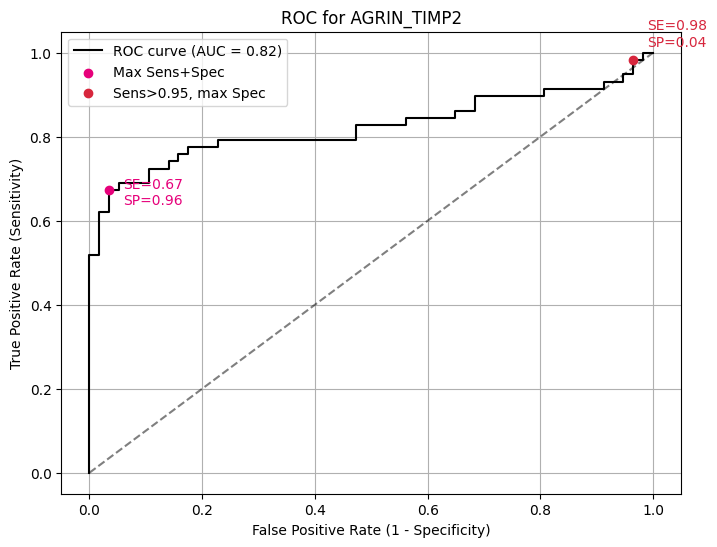

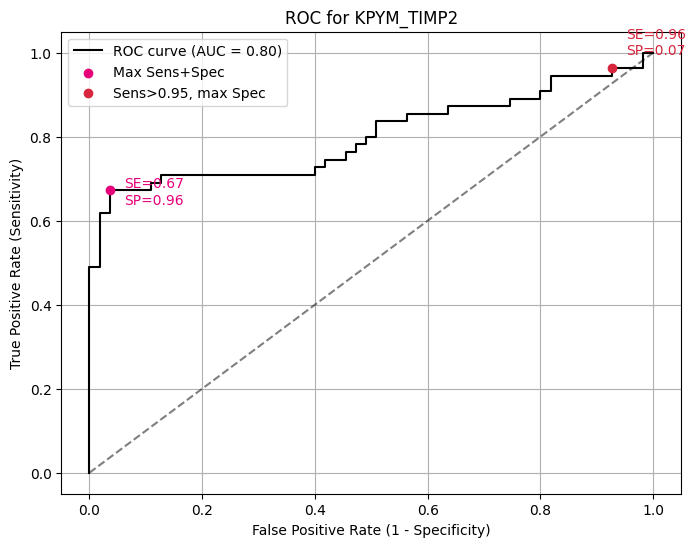

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_ratio_roc_mimark(df, ratio, pathology_col='Pathology', mimark_palette=None):
    """
    Plot ROC curve for a given ratio, highlighting and annotating:
    - Max specificity + sensitivity (Youden's J)
    - Max specificity with Sensitivity > 0.95
    Uses Mimark colors for highlights.
    """
    if mimark_palette is None:
        mimark_palette = {
            'max_sum': '#E6007A',  # Mimark pink
            'high_sens': '#D7263D',  # Mimark red
        }

    # Drop NaN
    df_valid = df[[ratio, pathology_col]].dropna()
    y_true = df_valid[pathology_col]
    y_score = df_valid[ratio]

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    specificity = 1 - fpr

    # Max sum criterion (Youden's J)
    sum_sens_spec = tpr + specificity
    optimal_idx = sum_sens_spec.argmax()

    # Sensitivity > 0.95, max specificity
    high_sens_indices = (tpr >= 0.95)
    if high_sens_indices.any():
        high_sens_opt_idx = specificity[high_sens_indices].argmax()
        high_sens_idx = high_sens_indices.nonzero()[0][high_sens_opt_idx]
    else:
        high_sens_idx = None

    # Plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='black')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    # Highlight max sum point
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color=mimark_palette['max_sum'], label='Max Sens+Spec', zorder=5)
    plt.annotate(f"SE={tpr[optimal_idx]:.2f}\nSP={specificity[optimal_idx]:.2f}",
                 (fpr[optimal_idx], tpr[optimal_idx]),
                 textcoords="offset points", xytext=(10,-10), ha='left', color=mimark_palette['max_sum'], fontsize=10)

    # Highlight high sensitivity point
    if high_sens_idx is not None:
        plt.scatter(fpr[high_sens_idx], tpr[high_sens_idx], color=mimark_palette['high_sens'], label='Sens>0.95, max Spec', zorder=5)
        plt.annotate(f"SE={tpr[high_sens_idx]:.2f}\nSP={specificity[high_sens_idx]:.2f}",
                     (fpr[high_sens_idx], tpr[high_sens_idx]),
                     textcoords="offset points", xytext=(10,10), ha='left', color=mimark_palette['high_sens'], fontsize=10)

    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'ROC for {ratio}')
    plt.legend()
    plt.grid()
    plt.savefig(f'/home/leandro/Desktop/ROC_{ratio}.svg', bbox_inches='tight', dpi=300, format='svg')
    plt.show()

# Example usage:
mimark_palette = {
    'max_sum': '#E6007A',  # Mimark pink
    'high_sens': '#D7263D',  # Mimark red
}
plot_ratio_roc_mimark(df_elisa, 'AGRIN_TIMP2', mimark_palette=mimark_palette)
plot_ratio_roc_mimark(df_elisa, 'KPYM_TIMP2', mimark_palette=mimark_palette)

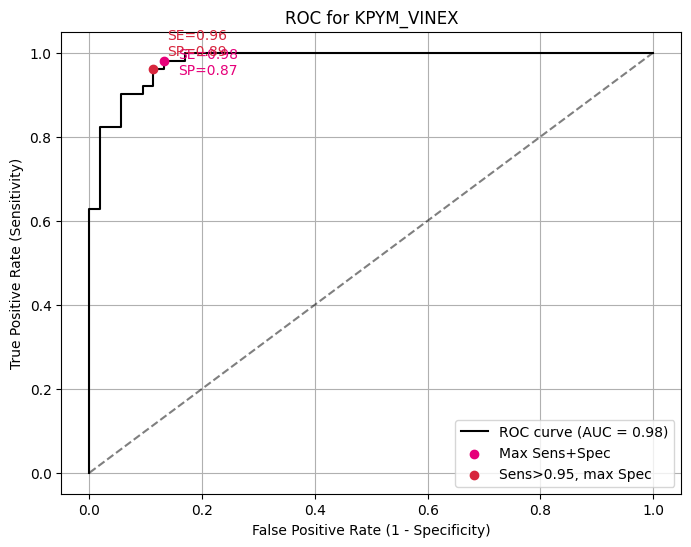

In [59]:
plot_ratio_roc_mimark(df_105_norm, 'KPYM_VINEX', mimark_palette=mimark_palette)


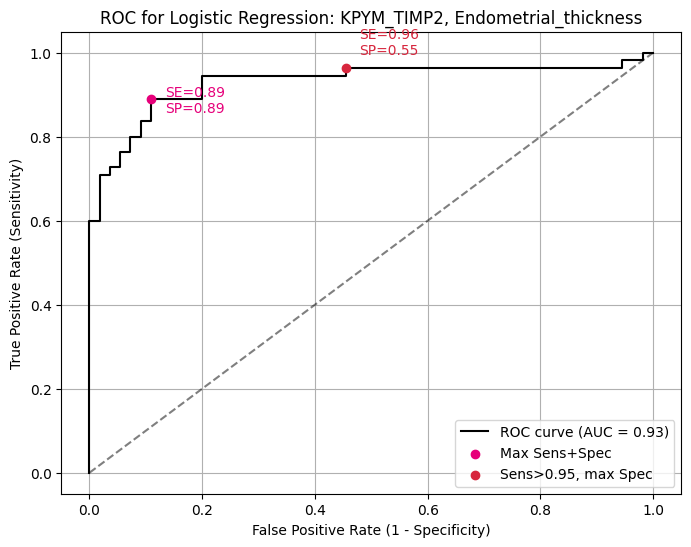

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

def plot_multivar_roc_mimark(df, variables, pathology_col='Pathology', mimark_palette=None):
    """
    Plot ROC curve for a logistic regression model using the given variables.
    Highlights and annotates:
    - Max specificity + sensitivity (Youden's J)
    - Max specificity with Sensitivity > 0.95
    Uses Mimark colors for highlights.
    """
    if mimark_palette is None:
        mimark_palette = {
            'max_sum': '#E6007A',  # Mimark pink
            'high_sens': '#D7263D',  # Mimark red
        }

    # Drop NaN
    df_valid = df[variables + [pathology_col]].dropna()
    y_true = df_valid[pathology_col]
    X = df_valid[variables]

    # Fit logistic regression
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y_true)
    y_score = model.predict_proba(X)[:, 1]

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    specificity = 1 - fpr

    # Max sum criterion (Youden's J)
    sum_sens_spec = tpr + specificity
    optimal_idx = sum_sens_spec.argmax()

    # Sensitivity > 0.95, max specificity
    high_sens_indices = (tpr >= 0.95)
    if high_sens_indices.any():
        high_sens_opt_idx = specificity[high_sens_indices].argmax()
        high_sens_idx = high_sens_indices.nonzero()[0][high_sens_opt_idx]
    else:
        high_sens_idx = None

    # Plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='black')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    # Highlight max sum point
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color=mimark_palette['max_sum'], label='Max Sens+Spec', zorder=5)
    plt.annotate(f"SE={tpr[optimal_idx]:.2f}\nSP={specificity[optimal_idx]:.2f}",
                 (fpr[optimal_idx], tpr[optimal_idx]),
                 textcoords="offset points", xytext=(10,-10), ha='left', color=mimark_palette['max_sum'], fontsize=10)

    # Highlight high sensitivity point
    if high_sens_idx is not None:
        plt.scatter(fpr[high_sens_idx], tpr[high_sens_idx], color=mimark_palette['high_sens'], label='Sens>0.95, max Spec', zorder=5)
        plt.annotate(f"SE={tpr[high_sens_idx]:.2f}\nSP={specificity[high_sens_idx]:.2f}",
                     (fpr[high_sens_idx], tpr[high_sens_idx]),
                     textcoords="offset points", xytext=(10,10), ha='left', color=mimark_palette['high_sens'], fontsize=10)

    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'ROC for Logistic Regression: {", ".join(variables)}')
    plt.legend()
    plt.grid()
    plt.savefig(f'/home/leandro/Desktop/ROC_LR_{"_".join(variables)}.svg', bbox_inches='tight', dpi=300, format='svg')
    plt.show()

# Example usage:
plot_multivar_roc_mimark(
    df_elisa,
    ['KPYM_TIMP2', 'Endometrial_thickness'],
    mimark_palette=mimark_palette
)